<a href="https://colab.research.google.com/github/NavneetSajwan/CIFAR10-Classifier-with-Fast.ai/blob/master/CIFAR10_classifier_with_Fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Resources**

In [0]:
from fastai import *
from fastai.vision import *
import os

**Mounting the drive to save my trained models permanently on my google drive.**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**Creating folders in drive to save the models at various checkpoints**

In [0]:
# os.mkdir('/content/drive/My Drive/fastai-v3/data/CIFAR10')
path_data = Path('/content/drive/My Drive/fastai-v3/data/CIFAR10')
# os.mkdir('/content/drive/My Drive/fastai-v3/data/CIFAR10/models')
path_model = path_data/'models'

**untar_data** function downloads the data and untars/unzips it. It returns the path where the data is being downloaded to.

In [0]:
path = untar_data(URLs.CIFAR)

In [21]:
path.ls() # returns the list of paths of all the items in the given path

[PosixPath('/root/.fastai/data/cifar10/models'),
 PosixPath('/root/.fastai/data/cifar10/train'),
 PosixPath('/root/.fastai/data/cifar10/labels.txt'),
 PosixPath('/root/.fastai/data/cifar10/test')]

# **Creating the Dataloaders**

In [0]:
np.random.seed(40)
data = (ImageList.from_folder(path).
        split_by_folder(train = 'train', valid = 'test').
        label_from_folder().
        transform(size = 128).
        databunch(bs = 1024).
        normalize(imagenet_stats))

The training data is a set of 50000 images and the validation data is a set of 10000 images. They are contained in the folders `train` and `test` respectively. So, we don't have to make the split manually instead they have been split beforehand. Hence, `split_by_folder(train = 'train', valid = 'test')`

The images are stored in IMAGENET style. So, labels for the data are obtained from folder names itself. Hence, `label_from_folder`

The sizes of images in the data are 32 by 32. But, since the ideal image size for the CNN architecture we use here(resnet34) is 224. So, we will be using higher size.

The trick we use here is called **Progressive resizing**. We first train the model on images of **size 128 by 128**. We train on it for a few epochs. Then, we increase the image size and train a little more. This **decreases the number of training epochs**.

We normalize the images using the imagenet stats.

In [0]:
data.show_batch(2)

# **Creating and training the model**

We begin with a **resnet34** model pretrained on Imagenet data


In [13]:
arch = models.resnet34
learn = cnn_learner(data, arch, metrics = accuracy)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 48.0MB/s]


We freeze the model and find an optimum learning rate. By freezing,we mean, we don't calculate and update the gradients of initial layers but just the last layers.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.02E-03
Min loss divided by 10: 3.02E-02


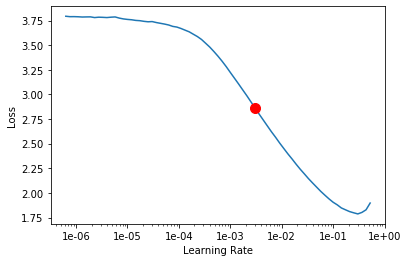

In [14]:
learn.freeze()
learn.lr_find()
learn.recorder.plot(suggestion = True)

In [0]:
learn.fit_one_cycle?

In [15]:
lr = 3e-2

# Training for 6 epochs
learn.fit_one_cycle(6, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.752114,0.369117,0.886500,01:21
1,0.415244,0.254875,0.921300,01:20
2,0.278356,0.221684,0.928000,01:20
3,0.197113,0.195232,0.937000,01:20
4,0.145976,0.195652,0.938700,01:20
5,0.113434,0.189483,0.940800,01:18


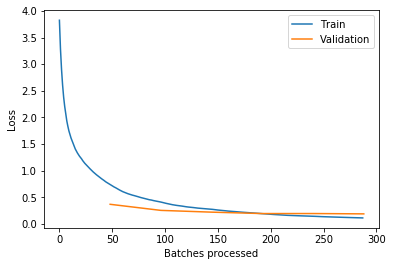

In [16]:
learn.recorder.plot_losses()

In [0]:
learn.save('stage-1-128-rn34')
# learn.load('stage-1-128-rn34')

So, we get an accuracy of 94% in just 6 epochs using the images of size 128. Now, we will increase the size of images to 224. We will have to create a new databunch with new image size.

In [0]:
np.random.seed(40)
data = (ImageList.from_folder(path).
        split_by_folder(train = 'train', valid = 'test').
        label_from_folder().
        transform(size = 224).
        databunch(bs = 128).
        normalize(imagenet_stats))

We now load our previously trained model that we saved in the drive.

In [0]:
arch = models.resnet34
learn =  cnn_learner(data, arch, metrics = accuracy).load('stage-1-128-rn34')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-06
Min loss divided by 10: 3.31E-03


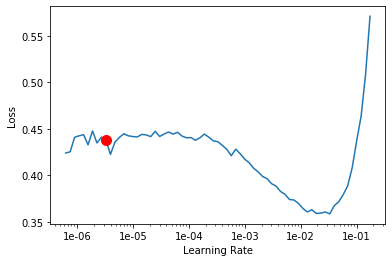

In [8]:
learn.freeze()
learn.lr_find()
learn.recorder.plot(suggestion = True)

In [10]:
lr = 3e-3

#retraining the freezed model for 6 epochs
learn.fit_one_cycle(6, lr) 

epoch,train_loss,valid_loss,accuracy,time
0,0.185258,0.181038,0.935800,02:58
1,0.195536,0.205893,0.933800,02:58
2,0.172261,0.189198,0.936800,02:55
3,0.132557,0.145709,0.951000,02:53
4,0.092223,0.134024,0.953900,02:50
5,0.063494,0.135797,0.954400,02:48


We have crossed the 95% accuracy mark in just 10 epochs. But, we retrain it further to see if we can get better accuracy.

In [0]:
learn.save(path_model/'stage-1-224-rn34')
# learn.load('stage-1-224-rn34')

We unfreeze the entire model and find the optimum lr.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 7.59E-08


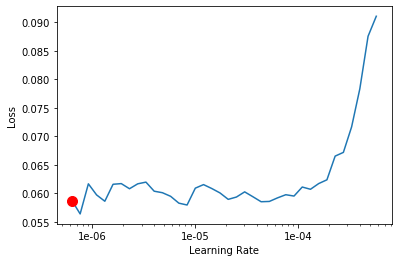

In [15]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion = True)

In [16]:
# we train the model for another 6 epochs
learn.fit_one_cycle(6, slice(3e-6, 3e-5) )

epoch,train_loss,valid_loss,accuracy,time
0,0.061793,0.132241,0.955600,03:05
1,0.056816,0.136857,0.954700,03:02
2,0.034822,0.131571,0.958300,03:00
3,0.019292,0.132713,0.958500,02:59
4,0.014804,0.132161,0.959600,02:59
5,0.011756,0.133340,0.958200,02:58


Finally, we end the training process with **95.8 % accuracy in total 18 epochs**

In [0]:
learn.save(path_model/'stage-2-224-rn34')
# learn.load(path_model/'stage-2-224-rn34')

In [19]:
interp = ClassificationInterpretation.from_learner(learn)

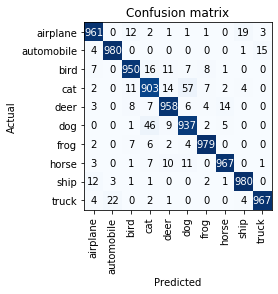

In [20]:
interp.plot_confusion_matrix()